In [1]:
!pip install gym_gridworlds

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import gym
import copy
import numpy as np 
import gym_gridworlds
import random
import matplotlib.pyplot as plt
import torch
from collections import namedtuple, deque
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

env = gym.make('WindyGridworld-v0')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


device(type='cuda')

In [3]:
env.reset()
I = [i for i in range(0, 7)] 
J = [i for i in range(0, 10)] 
A = [(i, j) for i in I for j in J]
Actions = ['Down','Right','Up','Left']

/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


#Q-Learning

In [4]:
def epsilon_gridy(e,action):
  if action == '*':
    return 1-e+e/4
  else:
    return e/4

In [6]:
env.reset()
alfa = 0.9
Gamma = [1, 0.5, 0.1]
e = 1 #epsilon, it muse decrease in each epoch
decay_rate = 0.005

Rewards = []

for gamma in Gamma:
  Reward = []
  e = 1
  Q = {(i, j): np.zeros([1,4]) for (i, j) in A} 
  policy = {(i, j): np.ones([1,4])/4 for (i, j) in A}
  for episode in range(500):
    env.reset()
    R = 0

    while True: #epochs

      s = env.S #current state

      if random.uniform(0,1) < e: # explore
        a = np.random.choice(np.arange(0, 4), p = policy[s][0])
      else:
        a = np.argmax(Q[s][0]) # exploit

      q_a = Q[s][0][a] 

      ns,r,done, info = env.step(a)
      na = np.argmax(policy[ns]) # ns = S', na = A', n_q_a = Q(S',A')
      n_q_a = Q[ns][0][na]

      if done == True: # check if we've got to the destination
        r = 0
        Q[s][0][a] = q_a + alfa*(r + gamma*n_q_a - q_a)
        break
      
      Q[s][0][a] = q_a + alfa*(r + gamma*n_q_a - q_a)
      R += r
    Reward.append(R)

    for (i, j) in A:
      best_action = np.argmax(Q[i,j][0])
      for a_ in range(4):
        if a_ == best_action:
          policy[i,j][0][a_] = epsilon_gridy(e,'*')
        else:
          policy[i,j][0][a_] = epsilon_gridy(e,' ')
    if e > 0.05:
      e = e - decay_rate 
  Rewards.append(Reward)
#--------------------------------------
  if gamma == 1:
    env.reset()
    while True: #epochs
      s = env.S #current state
      print('s =',s)
      a = np.argmax(policy[s])
      print(Actions[a])
      ns,r,done, info = env.step(a)
      if ns == (3,7): # check if we've got to the destination
        print('s =',ns)
        break
  # print('-------------------------------')
#--------------------------------------


s = (3, 0)
Right
s = (3, 1)
Right
s = (3, 2)
Right
s = (3, 3)
Right
s = (2, 4)
Right
s = (1, 5)
Right
s = (0, 6)
Right
s = (0, 7)
Right
s = (0, 8)
Right
s = (0, 9)
Up
s = (1, 9)
Up
s = (2, 9)
Up
s = (3, 9)
Up
s = (4, 9)
Left
s = (4, 8)
Left
s = (3, 7)


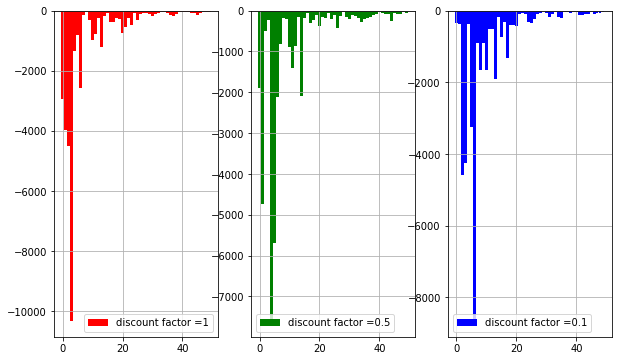

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(10, 6))
c = ['r','g','b']
ep = np.arange(50)
for f in range(3):
  ax[f].bar(ep, Rewards[f][0:50], label = f'discount factor ={Gamma[f]}',color = c[f])
  ax[f].grid()
  ax[f].legend()

#Actor-Critic

In [ ]:
def Policy_calculator(P,whole):
  Sum = 0
  for p in whole: 
    Sum = Sum + np.exp(p)
  return np.exp(P)/Sum

s = (3, 0)
Right
s = (3, 1)
Right
s = (3, 2)
Right
s = (3, 3)
Right
s = (2, 4)
Right
s = (1, 5)
Right
s = (0, 6)
Right
s = (0, 7)
Right
s = (0, 8)
Right
s = (0, 9)
Up
s = (1, 9)
Up
s = (2, 9)
Up
s = (3, 9)
Up
s = (4, 9)
Left
s = (4, 8)
Left
s = (3, 7)


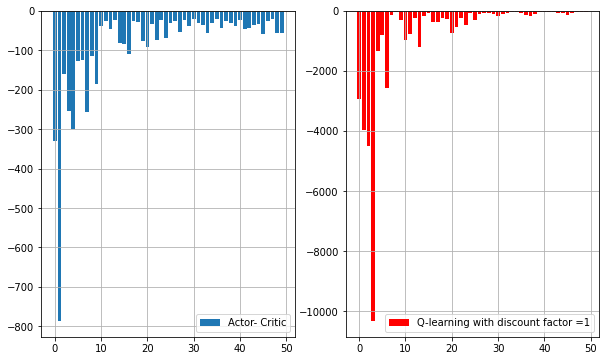

In [ ]:
env.reset()
policy = {(i, j): np.ones([1,4])/4 for (i, j) in A}
V = {(i, j): 0 for (i, j) in A} 
P = {(i, j): np.ones([1,4])/4 for (i, j) in A}

beta = 2**-3
alfa = 2**-2
gamma = 1
Reward = []
for loop in range(500):
  env.reset()
  R = 0
  while True: #epochs
    s = env.S 
    a = np.random.choice(np.arange(0, 4), p = policy[s][0])
    ns,r,done, info = env.step(a)

    if done == True: 
      r = 0
    R += r
    error = r + gamma*V[ns] - V[s]
    P[s][0][a] = P[s][0][a] + beta*error
    V[s] = V[s] + alfa*error
    for a_ in range(4):
      policy[s][0][a_] = Policy_calculator(P[s][0][a_],P[s][0])
    if done == True:
      Reward.append(R)
      break
#--------------------------------------
env.reset()
while True: #epochs
  s = env.S #current state
  print('s =',s)
  a = np.argmax(policy[s])
  print(Actions[a])
  ns,r,done, info = env.step(a)
  if ns == (3,7): # check if we've got to the destination
    print('s =',ns)
    break
#--------------------------------------
fig, ax = plt.subplots(1,2,figsize=(10, 6))

ax[0].bar(ep, Reward[0:50], label ='Actor- Critic')
ax[0].grid()
ax[0].legend()

ax[1].bar(ep, Rewards[0][0:50], label = f'Q-learning with discount factor ={Gamma[0]}',color = 'r')
ax[1].grid()
ax[1].legend()


#DQN

In [ ]:
# experience replay

class ExperienceReplay():
    Transition = namedtuple('Transition',
                        field_names=["state", "action", "reward", "next_state", "done"])
    def __init__(self, capacity) -> None:
        self.memory = deque([], maxlen=capacity)
        
    def store_trans(self, s, a, sp, r, done):
        t = self.Transition(s,a,sp,r,done)
        self.memory.append(t)
        

    def sample(self, batch_size):
        T = random.sample(self.memory, k=batch_size) # taking k transitions randomly from the memory
        
        # transform numpy arrays to vertical PyTorch tensors with torch.from_numpy on GPU
        
        S = torch.from_numpy(np.vstack([t.state for t in T if t is not None])).float().to(device) 

        A = torch.from_numpy(np.vstack([t.action for t in T if t is not None])).long().to(device)

        R = torch.from_numpy(np.vstack([t.reward for t in T if t is not None])).float().to(device)

        NS = torch.from_numpy(np.vstack([t.next_state for t in T if t is not None])).float().to(device)

        D = torch.from_numpy(np.vstack([t.done for t in T if t is not None]).astype(np.uint8)).float().to(device)
  
        return (S,A,R,NS,D)

    def __len__(self):
        return len(self.memory)

In [ ]:
#DQN
class DeepQNetwork(nn.Module):
    def __init__(self, state_size, action_size) -> None:
        super(DeepQNetwork, self).__init__()

        self.h1 = nn.Linear(state_size, 128)
        self.h2 = nn.Linear(128,64)
        self.out = nn.Linear(64, action_size)
        

    def forward(self, x):
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        estimate_Q = self.out(x)
        return estimate_Q

In [ ]:
# DDQN agent
    
class DDQNAgent():
    # NOTE: DON'T change initial values
    def __init__(self, state_size, action_size, batch_size,gamma=0.99, buffer_size=25000, alpha=1e-4):
        # network parameter
        self.state_size = state_size
        self.action_size = action_size

        # hyperparameters
        self.batch_size = batch_size
        self.gamma = gamma

        # experience replay
        self.experience_replay = ExperienceReplay(buffer_size)

        # network
        self.value_net = DeepQNetwork(state_size, action_size).to(device)
        self.target_net = DeepQNetwork(state_size, action_size).to(device)
        # optimizer
        self.optimizer = optim.Adam(self.value_net.parameters(),lr=alpha)  

    def take_action(self, state, eps=0.0):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.value_net.eval() 
        with torch.no_grad(): # disabled gradient calculation to reduce memory consumption for computations
            action_values = self.value_net(state)
        self.value_net.train()

        
        if random.random() > eps: #exploit
            return np.argmax(action_values.cpu().data.numpy())
        else:#explore
            return random.choice(np.arange(self.action_size))

    def update_params(self):
        if len(self.experience_replay) < self.batch_size:
            return
        # transition batch

        state_batch, action_batch, next_state_batch, reward_batch,done_batch  = self.experience_replay.sample(self.batch_size)


        Q_expected = self.value_net(state_batch).gather(1, action_batch)
        best_choice = self.target_net(next_state_batch).detach().max(1)[0].unsqueeze(1)
        y = reward_batch + self.gamma*(best_choice)*(1-done_batch) 
        loss = F.mse_loss(Q_expected,y)

        self.optimizer.zero_grad()
        loss.backward() 
        self.optimizer.step()              
        # ------------------- update target network ------------------- #
        self.update_target_network(tau = 1e-3)

    def update_target_network(self,tau):
        for target_param, local_param in zip(self.target_net.parameters(), self.value_net.parameters()):
          target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [ ]:
action_size = env.action_space.n  
state_size = len(list(env.observation_space))

In [ ]:
# training phase
def DDQN(BS):
  agent = DDQNAgent(state_size,action_size,batch_size=BS,gamma=0.99,buffer_size=25000,alpha=1e-4)

  n_episodes = 200

  eps = 1.0

  crs = [] # cummulative rewards
  crs_recent = deque(maxlen=25) # recent cummulative rewards

  # training loop
  for i_episode in range(1, n_episodes+1):
      state = env.reset()
      done=0  
      cr = 0 # episode cummulative rewards
      while not done:
          state = np.array(state)
          action = agent.take_action(state, eps)
          next_state, reward, done,info  = env.step(action)
          agent.experience_replay.store_trans(state,action,next_state,reward,done)
          agent.update_params()
          state = next_state
          cr += reward
      if eps > 0.01:
        eps = 0.99*eps
      crs_recent.append(cr)      
      crs.append(cr)

      print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps), end="")
      if i_episode % 25 == 0:
          print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps))
      
  plt.bar(np.arange(len(crs)),crs,label = "Cummulative Rewards")
  plt.title(f'Batch Size = {BS}')
  plt.ylabel('Score')
  plt.xlabel('#Episode')
  plt.legend(loc='lower right')
  plt.show()

  return agent,eps, crs

Episode 25	Average Reward: -970.96	Epsilon: 0.78
Episode 50	Average Reward: -84.16	Epsilon: 0.61
Episode 75	Average Reward: -56.56	Epsilon: 0.47
Episode 100	Average Reward: -39.80	Epsilon: 0.37
Episode 125	Average Reward: -27.92	Epsilon: 0.28
Episode 150	Average Reward: -21.08	Epsilon: 0.22
Episode 175	Average Reward: -21.24	Epsilon: 0.17
Episode 200	Average Reward: -19.68	Epsilon: 0.13


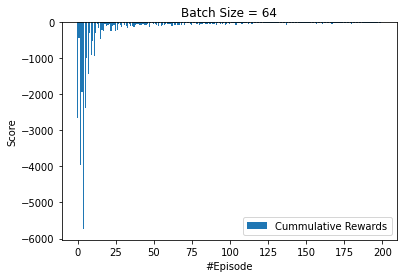

In [ ]:
agent,eps,crs = DDQN(64)

In [ ]:
env.reset()
while True: #epochs
  s = env.S #current state
  state = np.array(s)
  action = agent.take_action(state, eps)
  next_state, reward, done,info  = env.step(action)

  print('s =',s)
  print(Actions[action])
  if next_state == (3,7): # check if we've got to the destination
    print('s =',next_state)
    break

s = (3, 0)
Right
s = (3, 1)
Right
s = (3, 2)
Right
s = (3, 3)
Right
s = (2, 4)
Right
s = (1, 5)
Right
s = (0, 6)
Right
s = (0, 7)
Right
s = (0, 8)
Right
s = (0, 9)
Up
s = (1, 9)
Up
s = (2, 9)
Up
s = (3, 9)
Up
s = (4, 9)
Left
s = (4, 8)
Left
s = (3, 7)


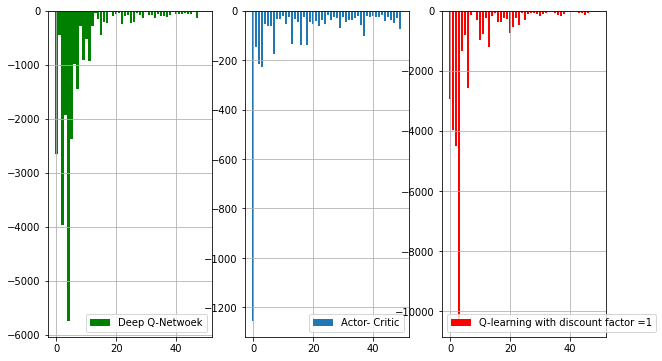

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(10, 6))

ax[1].bar(ep, Reward[0:50], label ='Actor- Critic')
ax[1].grid()
ax[1].legend()

ax[2].bar(ep, Rewards[0][0:50], label = f'Q-learning with discount factor ={Gamma[0]}',color = 'r')
ax[2].grid()
ax[2].legend()

ax[0].bar(ep, crs[0:50], label ='Double Deep Q-Netwoek',color = 'g')
ax[0].grid()
ax[0].legend()